In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Flatten, Dense, Input, Reshape
import numpy as np

In [2]:
from keras.preprocessing.image import ImageDataGenerator

# Autoencoder

In [61]:
BATCH_AE = 64
EPOCHS_AE = 10

In [3]:
src_path_train = "data\\train"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.10)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=1,
    subset='training',
    shuffle=True,
    seed=42,
    class_mode='input'  # делает так, чтобы и x, и y были x
)
val_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=1,
    subset='validation',
    shuffle=False,
    seed=42,
    class_mode='input'
)

Found 22497 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [33]:
a = next(iter(train_generator))

In [65]:
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='training',
    shuffle=True,
    seed=42,
    class_mode='input'  # делает так, чтобы и x, и y были x
)
val_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='validation',
    shuffle=False,
    seed=42,
    class_mode='input'
)

Found 22497 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


# Построение модели

In [107]:
encoder = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
    MaxPool2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
    MaxPool2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
    Flatten(), 
    Dense(1536, activation='leaky_relu')
])

decoder = Sequential([
    Input(shape=(1536,)),
    Dense(2048, activation='leaky_relu'),
    Reshape((8, 8, 32)),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
])

In [108]:
#encoded = encoder(a[0])
#decoder(encoded).shape
# autoencoder(image) # batch, width, heigth, channels

In [109]:
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [114]:
from keras.callbacks import LambdaCallback
from livelossplot import PlotLossesKeras

history = autoencoder.fit(
    train_generator,
    epochs=EPOCHS_AE,
    validation_data=val_generator,
    callbacks=[PlotLossesKeras()]
)

Epoch 1/10
 66/352 [====>.........................] - ETA: 2:28 - loss: 0.6102

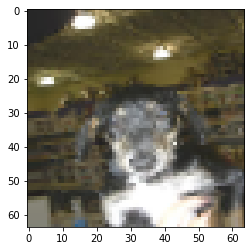

In [104]:
plt.imshow(a[0][3,:,:,:])

In [105]:
output = autoencoder(np.array([a[0][3,:,:,:]]))

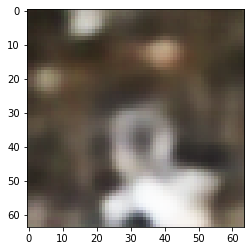

In [106]:
plt.imshow(output[0,:,:,:])